In [1]:
import os
import io
import glob
import netCDF4
import requests
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature

from matplotlib.collections import LineCollection
from matplotlib.path import Path
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib.image import imread
import matplotlib.colors

from scipy import stats
from scipy import interpolate

import datetime

In [2]:
#################
# Load ERA5 data
#################
#Path
#os.chdir('D:\\Bigfiles\\MICROAIRPOLAR\\Climatologia')
filename = 'ERA5_t2m_1950-2020.nc'

#Load netcdf
ncdf = netCDF4.Dataset(filename)

#Get dimensions
lons = ncdf.variables['longitude'][:]
lats = ncdf.variables['latitude'][:]
times = ncdf.variables['time'][:]

#Calculate datetime
dtimes = np.empty(len(times), dtype='datetime64[h]')
for i,t in enumerate(times):
    dtimes[i] = np.datetime64('1900-01-01') + np.timedelta64(int(t),'h')
dtimes = dtimes.astype('datetime64')

#Get variables
t2m = ncdf.variables['t2m'][:,:,:]-273.15

#Path
#os.chdir('D:\\Bigfiles\\MICROAIRPOLAR\\Climatologia')
filename = 'ERA5_orography.nc'

#Load netcdf
ncdf = netCDF4.Dataset(filename)

#Get dimensions
lonsZ = ncdf.variables['longitude'][:]
latsZ = ncdf.variables['latitude'][:]
#timesZ = ncdf.variables['time'][:]

#Calculate datetime
#dtimes = np.empty(len(times), dtype='datetime64[h]')
#for i,t in enumerate(times):
#    dtimes[i] = np.datetime64('1900-01-01') + np.timedelta64(int(t),'h')
#dtimes = dtimes.astype('datetime64')

#Get variables
Z = ncdf.variables['z'][:,:,:]/10

Orcadas
[-2.09608931]
6
Alert!!! This year is cold in ERA5
Alert!!! This year is cold in ERA5
Alert!!! This year is cold in ERA5
Alert!!! This year is cold in ERA5
Alert!!! This year is cold in ERA5
Alert!!! This year is cold in ERA5
Alert!!! This year is cold in ERA5
Alert!!! This year is cold in ERA5
Alert!!! This year is cold in ERA5
Alert!!! This year is cold in ERA5
Alert!!! This year is cold in ERA5
Alert!!! This year is cold in ERA5
Alert!!! This year is cold in Observations
Alert!!! This year is cold in ERA5
Alert!!! This year is cold in ERA5
Alert!!! This year is cold in ERA5
Alert!!! This year is cold in Observations
Alert!!! This year is cold in ERA5
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Alert!!! This year is cold in ERA5
Alert!!! This year is cold in ERA5
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
[142. 148. 155. 126. 144. 156. 150. 154. 101. 140. 129. 140. 127. 134.
 130. 2

[163.51408093]
10
Alert!!! This year is cold in ERA5
Alert!!! This year is cold in ERA5
Alert!!! This year is cold in ERA5
Alert!!! This year is cold in Observations
Alert!!! This year is cold in ERA5
Alert!!! This year is cold in ERA5
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
Data missing
[112. 131. 156. 150. 200. 130. 132. 123. 153. 124. 130. 125. 133. 139.
 139. 144. 135. 133. 141. 134. 127.  nan 128. 155.  nan  nan  nan 157.
 149. 125. 147. 120. 132. 135. 137. 132. 119.  nan 122. 132.  nan  nan
  nan

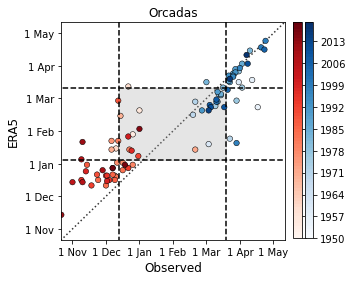

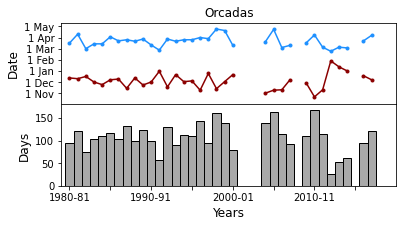

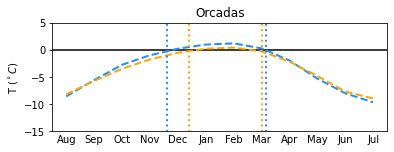

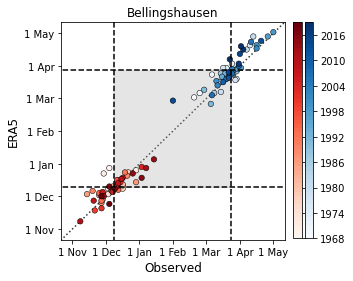

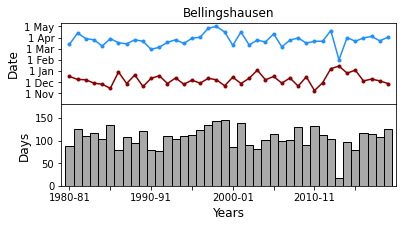

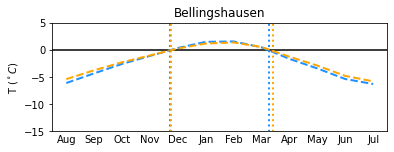

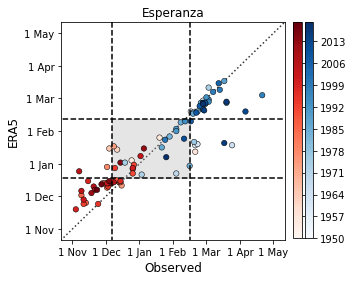

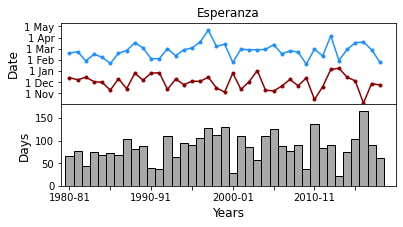

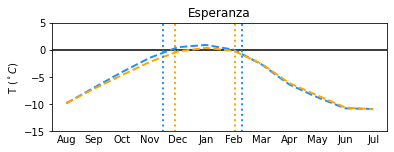

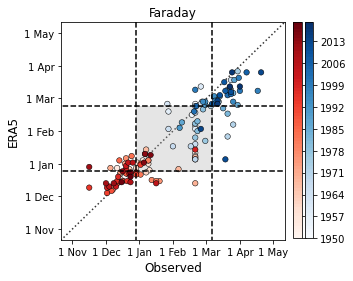

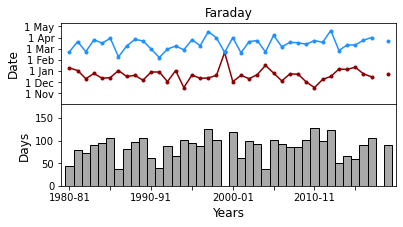

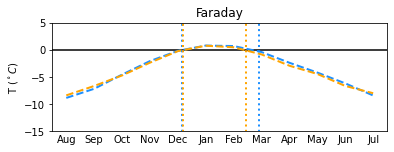

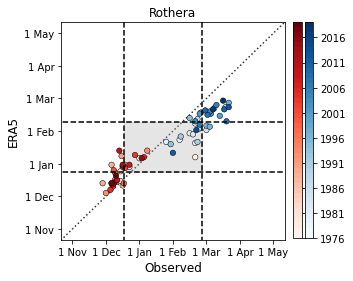

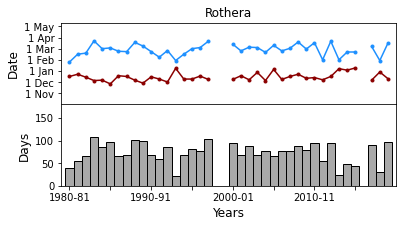

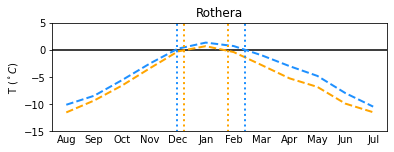

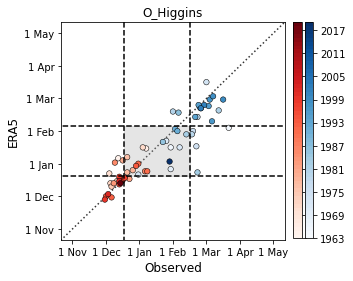

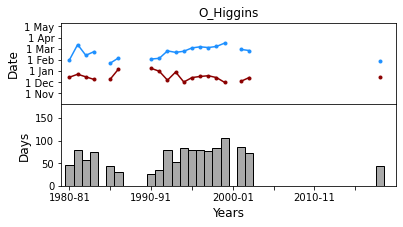

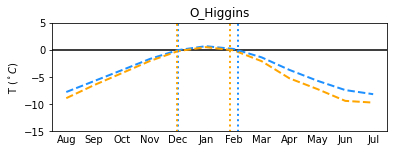

In [3]:
########################
#### MELTING SEASON #### Comparison between ERA5 and OBS MINI Version
########################

### DATA SETTINGS ###
url = 'https://legacy.bas.ac.uk/met/READER/surface/'
O_filenames = ['Orcadas','Bellingshausen','Esperanza','Faraday','Rothera','O_Higgins']
#O_filenames = ['Orcadas']
O_lat = [-60.7,-62.2,-63.4,-65.4,-67.5,-63.3]
O_lon = [-44.7,-58.9,-57.0,-64.4,-68.1,-57.9]
O_height = [6,16,13,11,32,10]

for i,(filename, lat, lon, O_height) in enumerate(zip(O_filenames[:], O_lat, O_lon, O_height)):
    print(filename)
    ### CALCULATE MELTING SEASON ###
    #Get ERA5 data
    Station_ERA5_timeseries = np.empty([np.size(dtimes)])
    for i in range(np.size(dtimes)):
        f = interpolate.interp2d(lons, lats, t2m[i,:,:], kind='linear')
        Station_ERA5_timeseries[i] = f(lon, lat)
    
    h = interpolate.interp2d(lons, lats, Z[0,:,:], kind='linear')
    Station_ERA5_height = h(lon, lat)
    print(Station_ERA5_height)
    print(O_height)
    
    # Get OBS data
    #print(url + filename + '.All.temperature.txt')
    s=requests.get(url + filename + '.All.temperature.txt').content
    #c=pd.read_csv(io.StringIO(s.decode('utf-8')))
    df = pd.read_csv(io.StringIO(s.decode('utf-8')), delim_whitespace=True, na_values='-', skiprows=1, names=['YEAR', 1,2,3,4,5,6,7,8,9,10,11,12])
    df = pd.melt(df, id_vars='YEAR', value_vars=[1,2,3,4,5,6,7,8,9,10,11,12], var_name='MONTH', value_name='T')
    df['DAY'] = 1
    df = df.sort_values(['YEAR', 'MONTH'])
    df['datetime'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
    df = df.drop(['YEAR','MONTH','DAY'], axis=1)
    df = df.set_index('datetime')

    year_ini = np.max([df.index.year[0], 1950])
    years_arr = range(year_ini,2020)
    
    # Get melting season of each station
    Station_ERA5_daysfrom1Aug_ini = np.empty([np.size(years_arr)]); Station_ERA5_daysfrom1Aug_ini[:] = np.nan
    Station_ERA5_daysfrom1Aug_end = np.empty([np.size(years_arr)]); Station_ERA5_daysfrom1Aug_end[:] = np.nan
    Station_OBS_daysfrom1Aug_end = np.empty([np.size(years_arr)]); Station_OBS_daysfrom1Aug_end[:] = np.nan
    Station_OBS_daysfrom1Aug_ini = np.empty([np.size(years_arr)]); Station_OBS_daysfrom1Aug_ini[:] = np.nan
    Data_Station_ERA5_AugtoJul = np.empty([12, np.size(years_arr)]); Data_Station_ERA5_AugtoJul[:] = np.nan
    Data_Station_OBS_AugtoJul = np.empty([12, np.size(years_arr)]); Data_Station_OBS_AugtoJul[:] = np.nan
    for i,year in enumerate(years_arr):
        #print(year)
        year_delay_ERA5 = np.max([df.index.year[0] - 1950,0])
        year_delay_OBS = np.min([df.index.year[0] - 1950,0])
        Station_ERA5_AugtoJul = Station_ERA5_timeseries[(i+year_delay_ERA5)*12+7:(i+year_delay_ERA5)*12+7+12] + 0.0065*(Station_ERA5_height-O_height)
        Station_OBS_AugtoJul = df['T'].values[(i-year_delay_OBS)*12+7:(i-year_delay_OBS)*12+7+12]
        Data_Station_ERA5_AugtoJul[:, i] = Station_ERA5_AugtoJul
        Data_Station_OBS_AugtoJul[:, i] = Station_OBS_AugtoJul
        #print(Station_ERA5_AugtoJul)
        #print(Station_OBS_AugtoJul)
        Months_AugtoJul = [8.5,9.5,10.5,11.5,12.5,13.5,14.5,15.5,16.5,17.5,18.5,19.5]
        
        if np.isnan(np.min(Station_OBS_AugtoJul)) == True:
            print('Data missing')
            Station_ERA5_daysfrom1Aug_ini[i] = np.nan
            Station_ERA5_daysfrom1Aug_end[i] = np.nan
        elif np.size(Station_ERA5_AugtoJul[Station_ERA5_AugtoJul>0]) == 0:
            print('Alert!!! This year is cold in ERA5')
            Station_ERA5_daysfrom1Aug_ini[i] = np.nan
            Station_ERA5_daysfrom1Aug_end[i] = np.nan
        else:
            ix_ini = np.where(np.diff(np.sign(Station_ERA5_AugtoJul)) != 0)[0][0]
            ix_end = np.where(np.diff(np.sign(Station_ERA5_AugtoJul)) != 0)[0][-1]

            if Station_ERA5_AugtoJul[0] > 0 :
                print('Alert!!! August is hot in era5')
                Station_ERA5_daysfrom1Aug_end[i] = np.nan
            else:
                Station_ERA5_MS_ini = np.interp(0, Station_ERA5_AugtoJul[ix_ini:ix_ini+2], Months_AugtoJul[ix_ini:ix_ini+2])
                Station_ERA5_daysfrom1Aug_ini[i] = int(int(Station_ERA5_MS_ini-8)*30 + np.round((Station_ERA5_MS_ini % 1)*30))
            if Station_ERA5_AugtoJul[-1] > 0 :
                print('Alert!!! July is hot in ERA5')
                Station_ERA5_daysfrom1Aug_end[i] = np.nan
            else:  
                Station_ERA5_MS_end = np.interp(0, np.flipud(Station_ERA5_AugtoJul[ix_end:ix_end+2]), np.flipud(Months_AugtoJul[ix_end:ix_end+2]))
                Station_ERA5_daysfrom1Aug_end[i] = int(int(Station_ERA5_MS_end-8)*30 + np.round((Station_ERA5_MS_end % 1)*30))

        if np.isnan(np.min(Station_OBS_AugtoJul)) == True:
            print('Data missing')
            Station_OBS_daysfrom1Aug_ini[i] = np.nan
            Station_OBS_daysfrom1Aug_end[i] = np.nan
        elif np.size(Station_OBS_AugtoJul[Station_OBS_AugtoJul>0]) == 0:
            print('Alert!!! This year is cold in Observations')
            Station_OBS_daysfrom1Aug_ini[i] = 200
            Station_OBS_daysfrom1Aug_end[i] = 200
        else:
            if Station_OBS_AugtoJul[0] > 0 :
                print('Alert!!! August is hot in Observations')
                Station_OBS_daysfrom1Aug_ini[i] = np.nan
            else:
                ix_ini = np.where(np.diff(np.sign(Station_OBS_AugtoJul)) != 0)[0][0]
                Station_OBS_MS_ini = np.interp(0, Station_OBS_AugtoJul[ix_ini:ix_ini+2], Months_AugtoJul[ix_ini:ix_ini+2])
                Station_OBS_daysfrom1Aug_ini[i] = int(int(Station_OBS_MS_ini-8)*30 + np.round((Station_OBS_MS_ini % 1)*30))

            if Station_OBS_AugtoJul[-1] > 0 :
                print('Alert!!! July is hot in Observations')
                print(year)
                Station_OBS_daysfrom1Aug_end[i] = np.nan
            else:
                ix_end = np.where(np.diff(np.sign(Station_OBS_AugtoJul)) != 0)[0][-1]
                Station_OBS_MS_end = np.interp(0, np.flipud(Station_OBS_AugtoJul[ix_end:ix_end+2]), np.flipud(Months_AugtoJul[ix_end:ix_end+2]))
                Station_OBS_daysfrom1Aug_end[i] =  int(int(Station_OBS_MS_end-8)*30 + np.round((Station_OBS_MS_end % 1)*30))
    print(Station_OBS_daysfrom1Aug_ini)
    print(Station_OBS_daysfrom1Aug_end)
    
    #### PLOT ERA5 - OBS COMPARISON ####
    # Create main figure
    fig = plt.figure(figsize=(4,4), facecolor='white')
    ax = plt.gca()

    #cmap and normalize
    cmap_I = plt.cm.Reds
    cmaplist = [cmap_I(i) for i in range(cmap_I.N)]
    cmap_I = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap_I.N)
    cmap_E = plt.cm.Blues
    maplist = [cmap_E(i) for i in range(cmap_E.N)]
    cmap_I = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap_E.N)
    bounds = np.arange(year_ini, 2020)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap_I.N)
    print(norm)

    #plot
    plt.fill_between([np.nanmean(Station_OBS_daysfrom1Aug_ini),np.nanmean(Station_OBS_daysfrom1Aug_end)], np.nanmean(Station_ERA5_daysfrom1Aug_ini), np.nanmean(Station_ERA5_daysfrom1Aug_end), color='DarkGray', alpha=0.3)
    plt.plot([np.nanmean(Station_OBS_daysfrom1Aug_ini), np.nanmean(Station_OBS_daysfrom1Aug_ini)], [0, 300], 'k--')
    plt.plot([np.nanmean(Station_OBS_daysfrom1Aug_end), np.nanmean(Station_OBS_daysfrom1Aug_end)], [0, 300], 'k--')
    plt.plot([0, 300], [np.nanmean(Station_ERA5_daysfrom1Aug_ini), np.nanmean(Station_ERA5_daysfrom1Aug_ini)], 'k--')
    plt.plot([0, 300], [np.nanmean(Station_ERA5_daysfrom1Aug_end), np.nanmean(Station_ERA5_daysfrom1Aug_end)], 'k--')
    CS_I = plt.scatter(Station_OBS_daysfrom1Aug_ini, Station_ERA5_daysfrom1Aug_ini, s=30, c=years_arr, cmap=cmap_I, norm=norm, edgecolors='k', linewidths=.5)
    CS_E = plt.scatter(Station_OBS_daysfrom1Aug_end, Station_ERA5_daysfrom1Aug_end, s=30, c=years_arr, cmap=cmap_E, norm=norm, edgecolors='k', linewidths=.5)

    #propierties
    plt.plot([0,500],[0,500], 'k:', zorder=-3, alpha=.8)
    ax.set_xlim(80,280)
    ax.set_ylim(80,280)
    ax.set_xticks([90,120,150,180,210,240,270])
    ax.set_xticklabels(['1 Nov','1 Dec','1 Jan','1 Feb','1 Mar','1 Apr','1 May'])
    ax.set_yticks([90,120,150,180,210,240,270])
    ax.set_yticklabels(['1 Nov','1 Dec','1 Jan','1 Feb','1 Mar','1 Apr','1 May'])
    ax.set_xlabel('Observed', fontsize=12)
    ax.set_ylabel('ERA5', fontsize=12)

    # Now adding the colorbar
    cbaxes_I = fig.add_axes([0.93, 0.13, 0.03, 0.75])
    CB_I = plt.colorbar(CS_I, cax = cbaxes_I, norm=norm, boundaries=bounds)
    plt.setp(cbaxes_I.get_yticklabels(), visible=False)
    cbaxes_E = fig.add_axes([0.97, 0.13, 0.03, 0.75])
    CB_E = plt.colorbar(CS_E, cax = cbaxes_E, norm=norm, boundaries=bounds)
    
    ax.set_title(filename)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0)
    plt.savefig('Mini_MeltingSeason_OBS_ERA5_' + filename + '.png', dpi=300)
    
    #### PLOT OBS MELTINGSEASON ####
    # Create main figure
    fig = plt.figure(figsize=(6,3), facecolor='white')
    ax1 = plt.subplot(2,1,1)
    ax2 = plt.subplot(2,1,2)

    #plot
    #plt.plot([0, np.nanmean(Station_ERA5_daysfrom1Aug_ini[-40:]), '--', color='DarkRed', linewidths=1)
    #plt.plot(years_arr[-40:], np.nanmean(Station_ERA5_daysfrom1Aug_end[-40:]), '--', color='DodgerBlue', linewidths=1)
    ax1.plot(years_arr[-40:], Station_OBS_daysfrom1Aug_ini[-40:], '.-', color='DarkRed', linewidth=1.5)
    ax1.plot(years_arr[-40:], Station_OBS_daysfrom1Aug_end[-40:], '.-', color='DodgerBlue', linewidth=1.5)
    ax2.bar(years_arr[-40:], Station_OBS_daysfrom1Aug_end[-40:]-Station_OBS_daysfrom1Aug_ini[-40:], width=1, color='DarkGray', ec='k', linewidth=1)

    #propierties
    ax1.set_xlim(1979,2020)
    ax2.set_xlim(1979,2020)
    ax1.set_ylim(60,280)
    ax2.set_ylim(0,180)
    ax1.set_xticks([])
    ax2.set_xticks([1980,1985,1990,1995,2000,2005,2010,2015])
    ax2.set_xticklabels(['1980-81','','1990-91','','2000-01','','2010-11',''])
    ax1.set_yticks([90,120,150,180,210,240,270])
    ax1.set_yticklabels(['1 Nov','1 Dec','1 Jan','1 Feb','1 Mar','1 Apr','1 May'])
    ax2.set_xlabel('Years', fontsize=12)
    ax1.set_ylabel('Date', fontsize=12)
    ax2.set_ylabel('Days', fontsize=12)

    ax1.set_title(filename)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0)
    plt.savefig('YearlyMeltingSeason_OBS_' + filename + '.png', dpi=300)

    
    #### PLOT ERA5 - OBS EVOLUTION ####
    plt.figure(figsize=(6,2))
    ax = plt.gca()
    ax.plot([0,30*12+15], [0,0], 'k-')
    ax.plot(np.arange(15,30*12,30), np.nanmean(Data_Station_OBS_AugtoJul[-40:], axis=1), '--', color='DodgerBlue', linewidth=2)
    plt.plot(np.arange(15,30*12,30), np.nanmean(Data_Station_ERA5_AugtoJul[-40:], axis=1), '--', color='Orange', linewidth=2)
    plt.plot([np.nanmean(Station_OBS_daysfrom1Aug_ini[-40:]),np.nanmean(Station_OBS_daysfrom1Aug_ini[-40:])], [-20,10], ':', color='DodgerBlue', linewidth=2)
    plt.plot([np.nanmean(Station_OBS_daysfrom1Aug_end[-40:]),np.nanmean(Station_OBS_daysfrom1Aug_end[-40:])], [-20,10], ':', color='DodgerBlue', linewidth=2)
    plt.plot([np.nanmean(Station_ERA5_daysfrom1Aug_ini[-40:]),np.nanmean(Station_ERA5_daysfrom1Aug_ini[-40:])], [-20,10], ':', color='Orange', linewidth=2)
    plt.plot([np.nanmean(Station_ERA5_daysfrom1Aug_end[-40:]),np.nanmean(Station_ERA5_daysfrom1Aug_end[-40:])], [-20,10], ':', color='Orange', linewidth=2)
    ax.set_xticks(np.arange(15,30*12,30))
    ax.set_xticklabels(['Aug', 'Sep', 'Oct', 'Nov','Dec','Jan','Feb','Mar','Apr','May', 'Jun', 'Jul'])
    ax.tick_params(axis='x', which='major', length=0)
    ax.tick_params(axis='x', which='minor', length=5, color='k')
    ax.set_xlim(0,30*12)
    ax.set_ylabel('T ($^\circ C$)')
    ax.set_yticks([-15,-10,-5,0,5])
    ax.set_ylim(-15,5)
    ax.set_title(filename)
    plt.savefig('Tevol_OBS_ERA5_' + filename + '.png', dpi=300)
    
    ### CALCULATE STATISTICS ###
    #Create dataframe
    data = {'OBS_Ini': Station_OBS_daysfrom1Aug_ini[-40:],
            'OBS_End': Station_OBS_daysfrom1Aug_end[-40:],
            'ERA5_Ini': Station_ERA5_daysfrom1Aug_ini[-40:],
            'ERA5_End': Station_ERA5_daysfrom1Aug_end[-40:],
            }

    df = pd.DataFrame (data, columns = ['OBS_Ini','OBS_End','ERA5_Ini','ERA5_End'], index=years_arr[-40:])

    #print (df)

    #Test between datasets
    from scipy.stats import linregress
    print('')
    print('SEASON from 1980 to 2019')
    #print(df['OBS_End'] - df['OBS_Ini'])
    print('MAX SEASON: ' + str(int(np.max(df['OBS_End'] - df['OBS_Ini']))))
    print('MIN SEASON: ' + str(int(np.min(df['OBS_End'] - df['OBS_Ini']))))
    print('MEAN SEASON: ' + str(np.around(np.mean(df['OBS_End'] - df['OBS_Ini']),2)))
    print('STD SEASON: ' + str(np.around(np.std(df['OBS_End'] - df['OBS_Ini']),2)))
    print('DAY INI MIN-MEAN-MAX: ' + str(int(np.min(df['OBS_Ini']))) + ' ' + str(np.around(np.nanmean(df['OBS_Ini']),2)) + ' ' + str(int(np.max(df['OBS_Ini']))))
    print('DAY END MIN-MEAN-MAX: ' + str(int(np.min(df['OBS_End']))) + ' ' + str(np.around(np.nanmean(df['OBS_End']),2)) + ' ' + str(int(np.max(df['OBS_End']))))
    #days from 1 Aug

    print('')
    print('ERROR')
    print('mean')
    print(np.around(np.mean(np.abs(df['OBS_Ini'] - df['ERA5_Ini'])),2))
    print(np.around(np.mean(np.abs(df['OBS_End'] - df['ERA5_End'])),2))
    print('max')
    print(np.max(np.abs(df['OBS_Ini'] - df['ERA5_Ini'])))
    print(np.max(np.abs(df['OBS_End'] - df['ERA5_End'])))

    print('')
    print('BIAS')
    print('mean')
    print(np.around(np.mean(df['OBS_Ini'] - df['ERA5_Ini']),2))
    print(np.around(np.mean(df['OBS_End'] - df['ERA5_End']),2))

    #print('')
    #mask_ini = ~np.isnan(df['OBS_Ini']) & ~np.isnan(df['ERA5_Ini'])
    #mask_end = ~np.isnan(df['OBS_End']) & ~np.isnan(df['ERA5_End'])
    #print('REGRESSIÓ LINEAL')
    #print(linregress(df['OBS_Ini'][mask_ini], df['ERA5_Ini'][mask_end]))
    #print(linregress(df['OBS_End'][mask_end], df['ERA5_End'][mask_end]))

    print('')
    print('TREND')
    mask_ini = ~np.isnan(df['OBS_Ini'])
    mask_end = ~np.isnan(df['OBS_End'])
    slope_Ini, intercept_Ini, r_value_Ini, p_value_Ini, std_err_Ini = stats.linregress(df['OBS_Ini'].index[mask_ini], df['OBS_Ini'][mask_ini])
    slope_End, intercept_End, r_value_End, p_value_End, std_err_End = stats.linregress(df['OBS_End'].index[mask_end], df['OBS_End'][mask_end])
    print('Trend Ini: ' + str(slope_Ini*10) + '\t pvalue Ini: ' + str(p_value_Ini) + '\t std_err Ini: ' + str(std_err_Ini))
    print('Trend End: ' + str(slope_End*10) + '\t pvalue End: ' + str(p_value_End) + '\t std_err End: ' + str(std_err_End))
    print('\n\n\n')
    print('----------------------------------------------------------------------')

In [4]:
#################
# Observational dataset
#################

##################
# Load data
url = 'https://legacy.bas.ac.uk/met/READER/surface/'
filename = 'Bellingshausen'
s=requests.get(url + filename + '.All.temperature.txt').content

df_B = pd.read_csv(io.StringIO(s.decode('utf-8')), delim_whitespace=True, na_values='-', skiprows=1, names=['YEAR', 1,2,3,4,5,6,7,8,9,10,11,12])
df_B = pd.melt(df_B, id_vars='YEAR', value_vars=[1,2,3,4,5,6,7,8,9,10,11,12], var_name='MONTH', value_name='T')
df_B['DAY'] = 1
df_B = df_B.sort_values(['YEAR', 'MONTH'])
df_B['datetime'] = pd.to_datetime(df_B[['YEAR', 'MONTH', 'DAY']])
df_B = df_B.drop(['YEAR','MONTH','DAY'], axis=1)
df_B = df_B.set_index('datetime')

print(df_B)


##################
# Get melting season of each station
Bellingshausen_OBS_daysfrom1Aug_end = np.empty([np.size(years_arr)])
Bellingshausen_OBS_daysfrom1Aug_ini = np.empty([np.size(years_arr)])    

years_arr = range(1969,2020)
for i,year in enumerate(years_arr):
    print(year)
    year_delay_OBS = np.min([df_B.index.year[0] - 1950,0])
    Bellingshausen_OBS_AugtoJul = df_B['T'].values[(i-year_delay_OBS)*12+7:(i-year_delay_OBS)*12+7+12]
    print(Bellingshausen_OBS_AugtoJul)
    Months_AugtoJul = [8.5,9.5,10.5,11.5,12.5,13.5,14.5,15.5,16.5,17.5,18.5,19.5]
        
    if np.size(Bellingshausen_OBS_AugtoJul[Bellingshausen_OBS_AugtoJul>0]) == 0:
        print('Alert!!! This year is cold')
        Bellingshausen_ERA5_daysfrom1Aug_ini[i] = np.nan
        Bellingshausen_ERA5_daysfrom1Aug_end[i] = np.nan
    else:
        if Bellingshausen_OBS_AugtoJul[0] > 0 :
            print('Alert!!! August is hot')
            Bellingshausen_OBS_daysfrom1Aug_ini[i] = np.nan
        else:
            ix_ini = np.where(np.diff(np.sign(Bellingshausen_OBS_AugtoJul)) != 0)[0][0]
            Bellingshausen_OBS_MS_ini = np.interp(0, Bellingshausen_OBS_AugtoJul[ix_ini:ix_ini+2], Months_AugtoJul[ix_ini:ix_ini+2])
            Bellingshausen_OBS_daysfrom1Aug_ini[i] = int(int(Bellingshausen_OBS_MS_ini-8)*30 + np.round((Bellingshausen_OBS_MS_ini % 1)*30))
            
        if Bellingshausen_OBS_AugtoJul[-1] > 0 :
            print('Alert!!! July is hot')
            print(year)
            Bellingshausen_OBS_daysfrom1Aug_end[i] = np.nan
        else:
            ix_end = np.where(np.diff(np.sign(Bellingshausen_OBS_AugtoJul)) != 0)[0][-1]
            Bellingshausen_OBS_MS_end = np.interp(0, np.flipud(Bellingshausen_OBS_AugtoJul[ix_end:ix_end+2]), np.flipud(Months_AugtoJul[ix_end:ix_end+2]))
            Bellingshausen_OBS_daysfrom1Aug_end[i] =  int(int(Bellingshausen_OBS_MS_end-8)*30 + np.round((Bellingshausen_OBS_MS_end % 1)*30))

              T
datetime       
1968-01-01  NaN
1968-02-01  NaN
1968-03-01 -0.4
1968-04-01 -1.3
1968-05-01 -5.5
...         ...
2023-08-01 -3.8
2023-09-01 -5.0
2023-10-01  NaN
2023-11-01  NaN
2023-12-01  NaN

[672 rows x 1 columns]
1969
[-5.8 -3.9 -2.5 -0.8  0.5  0.5  0.3 -1.8 -3.7 -5.5 -9.6 -8.1]
1970
[-7.2 -3.2 -5.1 -2.2  0.2  0.7  0.5 -1.1 -3.3 -7.5 -8.7 -3.7]
1971
[-6.1 -1.5 -1.4 -0.3  0.4  1.6  1.   0.7 -1.1 -6.6 -2.7 -4.5]
1972
[-6.2 -4.3 -1.4 -0.3 -0.7  1.1  0.6 -0.3 -2.7 -3.2 -7.3 -5.7]
1973
[-10.1  -4.4  -2.4  -1.3   1.    0.1   1.2   0.2  -2.1  -5.8  -8.8  -6.8]
1974
[-4.9 -5.6 -2.3 -0.8  0.5  1.4  2.2  1.3 -3.3 -3.8 -5.3 -5. ]
1975
[ -7.8  -5.1  -1.8  -1.4   1.1   1.3   1.    0.6  -1.4  -4.6  -7.3 -11.5]
1976
[-10.6  -4.7  -1.3  -1.3   0.2   1.    1.9   0.8  -0.2  -2.6  -5.1 -10.3]
1977
[-8.3 -6.2 -2.6 -0.6 -0.2  1.   1.3  0.  -0.7 -2.5 -4.8 -8.3]
1978
[ -8.1  -7.1  -3.4  -0.6   0.    1.4   1.9   0.5  -0.9  -1.1  -4.9 -11. ]
1979
[-7.8 -3.5 -2.  -1.8  0.   2.1  1.8  1.  -0.4

In [ ]:
##################
## Example
##################
#
##### PLOT ERA5 - OBS EVOLUTION ####
#plt.figure(figsize=(16,2))
#ax = plt.gca()
#ax.plot([df_B[-101:-53].index[0],df_B[-89:-41].index[-1]],[0,0], 'k-')
#ax.plot(df_B[-89:-41].index+datetime.timedelta(days=14), df_B[-89:-41].values, '.-', color='Gray')
#
#ax.plot
#
#ax.set_xlim([df_B[-89:-41].index[0],df_B[-89:-41].index[-1]])
#ax.set_ylim([-7,4])
#
#for i in range(0,4):
#    ax.plot([datetime.date(2016, 8, 1) + datetime.timedelta(days=Bellingshausen_OBS_daysfrom1Aug_ini[-5:][i]+365*i), datetime.date(2016, 8, 1) + datetime.timedelta(days=Bellingshausen_OBS_daysfrom1Aug_ini[-5:][i]+365*i)], [-10,10], '--', color='DarkRed')
#    ax.plot([datetime.date(2016, 8, 1) + datetime.timedelta(days=Bellingshausen_OBS_daysfrom1Aug_end[-5:][i]+365*i), datetime.date(2016, 8, 1) + datetime.timedelta(days=Bellingshausen_OBS_daysfrom1Aug_end[-5:][i]+365*i)], [-10,10], '--', color='DodgerBlue')
#    
#for i in range(0,80):
#    ax.plot([datetime.date(2016, 8, 1) + datetime.timedelta(i*365/12), datetime.date(2016, 8, 1) + datetime.timedelta(i*365/12)], [-.2,.2], '-', color='k')